# Customer Review Project - Contentsquare

## Problem statement

**_Context_**

Contentsquare is a french cloud-based platform that helps business understand how and why users are interacting with their app, mobile and website. Its SaaS analyses customer behaviour through billions of anonymous web, mobile and app interactions. It then provides recommendations, with the goal of helping companies increase revenue, engagement and growth.

In this project I will show you how to realiaze an analysis to determine what customers think about Contentsquare and their SaaS.

**_Instructions_**

I made a Python script to scrape all review from Trustpilot, stock all the data in a Google Spreadsheets via API and process a word frequency analysis. 

Scraping was done with BeautifulSoup library. The analysis was done using nltk/matplotlib library.

1. Scrap website of trustpilot to get all the data necessary
2. Clear the data if necessary and Export data to a GS that we will conect via our API (This data will be stocked there and everytime we run this script, we will update the GS)
3. Analysis
4. Conclusions


## Scrap Website of Trustpilot

In [ ]:
#Import necessary libraries
import requests
import re
import numpy as np
from bs4 import BeautifulSoup
from tqdm import tqdm

In [ ]:
url = 'https://fr.trustpilot.com/review/contentsquare.com?languages=all&page=2'
page = requests.get(url)
soup = BeautifulSoup(page.content)

In [5]:
nb_reviews_string = soup.find('span', class_="typography_typography__QgicV typography_bodysmall__irytL typography_color-gray-7__9Ut3K typography_weight-regular__TWEnf typography_fontstyle-normal__kHyN3 styles_text__W4hWi").text
nb_reviews = re.sub("[^0-9]","", nb_reviews_string)
print(f'The number of reviews for Contentsquare available on Truspilot is {nb_reviews}.')

The number of reviews for Contentsquare available on Truspilot is 87.


In [43]:
#Create list with number of pages (Important to update the range if the website has new review pages)
l = []
for i in range(1, 6):
    l.append(i)
print(l)

[1, 2, 3, 4, 5]


In [50]:
#Get all review pages
urls = []
for i in l:
    url = 'https://fr.trustpilot.com/review/contentsquare.com?languages=all&page={}'.format(i)
    urls.append(url)
urls

['https://fr.trustpilot.com/review/contentsquare.com?languages=all&page=1',
 'https://fr.trustpilot.com/review/contentsquare.com?languages=all&page=2',
 'https://fr.trustpilot.com/review/contentsquare.com?languages=all&page=3',
 'https://fr.trustpilot.com/review/contentsquare.com?languages=all&page=4',
 'https://fr.trustpilot.com/review/contentsquare.com?languages=all&page=5']

In [51]:
#Test 1 link
url_review_1 = urls[1]
page = requests.get(url_review_1)
print(page)
page_1 = BeautifulSoup(page.content)

<Response [200]>


In [52]:
#Informations to scrap
#Name
#Number of Reviews
#Country
#Rating
#Full comment
#Date

In [ ]:
#Build an empty dictionary to stock all the data
dic = {'name' : [], 'nb_reviews_page': [], 'rating' :[], 'commentaire' : [], 'date' : []}

#Loop to get the data for each review for all pages (urls) of the trustpilot website
for url in tqdm(urls) : 

    page = requests.get(url)
    product = BeautifulSoup(page.content)

    #NAME
    name = product.find_all('div', class_='typography_typography__QgicV typography_bodysmall__irytL typography_weight-medium__UNMDK typography_fontstyle-normal__kHyN3 styles_consumerName__dP8Um')
    for i in name :
        dic['name'].append(i.text)

    #NB Reviews // Country 
    liste = []
    nb_reviews_page = product.find_all('div', {'class':'typography_typography__QgicV typography_bodysmall__irytL typography_color-gray-6__TogX2 typography_weight-regular__TWEnf typography_fontstyle-normal__kHyN3 styles_detailsIcon__Fo_ua'})
    for y in nb_reviews_page:
        liste.append(y.text)
    for z in liste :
        if 'avis' in z:
            dic['nb_reviews_page'].append(z)
    #Reviews
    reviews = product.find_all('section', {'class' : 'styles_reviewContentwrapper__zH_9M'})
    for e in reviews:
        try : 
            dic['commentaire'].append(e.find('p', {'data-service-review-text-typography':'true'}).text)
        except : 
            dic['commentaire'].append(e.find('a', {'data-review-title-link':'true'}).text)
            
    #Date + Rating
    for u in reviews:
        #dic['date'].append(u.find('time', {'data-service-review-date-time-ago' : 'true'})['datetime'])
        try :
            dic['date'].append(u.find('time', {'data-service-review-date-time-ago' : 'true'})['datetime'])
            dic['rating'].append(float(u.find('div', {'class' :'styles_reviewHeader__iU9Px' })['data-service-review-rating']))
        except :
            pass;

In [54]:
#Verify lengih before printing
print(len(dic['name']))
print(len(dic['nb_reviews_page']))
print(len(dic['rating']))
print(len(dic['commentaire']))
print(len(dic['date']))

84
84
84
84
84


In [55]:
import pandas as pd

In [56]:
#Clear Dataframe before saving it
df = pd.DataFrame(dic)
df['nb_reviews_page'] = df['nb_reviews_page'].str.replace(" avis","")

In [ ]:
#Count number of nan by column
df.isna().sum()

In [59]:
#Save doc on my folder
df.to_csv('data_Contentsquare_CSV.csv', encoding='utf-8', index=False)

In [60]:
print(len(df.values))

84


## Export to GS

In [ ]:
!pip install gspread==5.3.0;

In [62]:
import gspread

In [63]:
#Insert the path to your json account here
path = 'level-chassis-345709-4deccf52db36.json'
gc = gspread.service_account(filename=path)


In [64]:
#Insert the id of your spreadsheet where you wanna stock the data
file = gc.open_by_key('1Ju8TeGJtARGHnAL8LizQ31vBirCQKQixgvTvz42eRqg').sheet1
worksheet = file
worksheet

<Worksheet 'Feuille 1' id:0>

In [65]:
#This function is to clear the document every time we execute this script. Remove it if you wanna stock your data
worksheet.clear()

{'spreadsheetId': '1Ju8TeGJtARGHnAL8LizQ31vBirCQKQixgvTvz42eRqg',
 'clearedRange': "'Feuille 1'!A1:Z16000"}

In [66]:
worksheet.append_row(list(df.columns))

{'spreadsheetId': '1Ju8TeGJtARGHnAL8LizQ31vBirCQKQixgvTvz42eRqg',
 'updates': {'spreadsheetId': '1Ju8TeGJtARGHnAL8LizQ31vBirCQKQixgvTvz42eRqg',
  'updatedRange': "'Feuille 1'!A1:E1",
  'updatedRows': 1,
  'updatedColumns': 5,
  'updatedCells': 5}}

In [67]:
#Its necessary to fill df with '' because does not accept nans
df = df.fillna('')
df

,name,nb_reviews_page,rating,commentaire,date
0,Karina Jeribi,1,5.0,J'utilise cet outil depuis plusieurs années et...,2022-02-17T10:33:31.000Z
1,Amélie B,1,5.0,J'ai été formée récemment à l'utilisation de c...,2022-02-14T15:21:34.000Z
2,Margarita D.S.,1,5.0,Très utile pour analyser nos parcours digitaux...,2022-02-14T13:50:04.000Z
3,Miguel,1,5.0,"Détails des statistiques, accompagnement des c...",2022-02-14T08:31:01.000Z
4,Anna,1,5.0,ne pas hésitez à se lancer sur cette plateform...,2022-02-14T08:25:12.000Z
...,...,...,...,...,...
79,Steve Thomson,1,5.0,ContentSquare has added another layer of detai...,2020-08-12T13:02:25.000Z
80,Amelia di Palma,2,5.0,I use content square to gather customer insigh...,2020-08-12T13:00:09.000Z
81,Dunia Rey,1,5.0,A handy tool that supported the UX team to del...,2020-08-12T12:58:53.000Z
82,Michael Everitt,1,5.0,ContentSquare has provided so many insights an...,2020-08-12T12:54:11.000Z


In [68]:
worksheet.update('A2', df.values.tolist())

{'spreadsheetId': '1Ju8TeGJtARGHnAL8LizQ31vBirCQKQixgvTvz42eRqg',
 'updatedRange': "'Feuille 1'!A2:E85",
 'updatedRows': 84,
 'updatedColumns': 5,
 'updatedCells': 420}

In [69]:
#Check your spreadsheets
#url = https://docs.google.com/spreadsheets/d/1Ju8TeGJtARGHnAL8LizQ31vBirCQKQixgvTvz42eRqg/edit?usp=sharing

## Analysis

In [70]:
from nltk.corpus import stopwords

final_stopwords_list = stopwords.words('english') + stopwords.words('french')

In [71]:
#There still a lot of stop words, so we will add them to our dictionary and clear again the df
#extra_words = ['a', 'cest', 'je', 'bonjouroui', 'leurs', 'foidtrès', 'je']

In [72]:
#final_stopwords = final_stopwords_list + extra_words

In [73]:
#We create a copy to do not modify main dataframe
df_test = df.copy()

In [74]:
# We remove all stopwrods in order to have a clean test
df_test['commentaire sans stop words'] = df_test['commentaire'].apply(lambda x: ' '.join([word for word in x.split() if word not in (final_stopwords_list)]))

In [75]:
df_test

,name,nb_reviews_page,rating,commentaire,date,commentaire sans stop words
0,Karina Jeribi,1,5.0,J'utilise cet outil depuis plusieurs années et...,2022-02-17T10:33:31.000Z,J'utilise cet outil depuis plusieurs années l'...
1,Amélie B,1,5.0,J'ai été formée récemment à l'utilisation de c...,2022-02-14T15:21:34.000Z,J'ai formée récemment l'utilisation logiciel. ...
2,Margarita D.S.,1,5.0,Très utile pour analyser nos parcours digitaux...,2022-02-14T13:50:04.000Z,Très utile analyser parcours digitaux. J'appré...
3,Miguel,1,5.0,"Détails des statistiques, accompagnement des c...",2022-02-14T08:31:01.000Z,"Détails statistiques, accompagnement clients e..."
4,Anna,1,5.0,ne pas hésitez à se lancer sur cette plateform...,2022-02-14T08:25:12.000Z,hésitez lancer cette plateforme car possibilit...
...,...,...,...,...,...,...
79,Steve Thomson,1,5.0,ContentSquare has added another layer of detai...,2020-08-12T13:02:25.000Z,ContentSquare added another layer detail view ...
80,Amelia di Palma,2,5.0,I use content square to gather customer insigh...,2020-08-12T13:00:09.000Z,I use content square gather customer insights ...
81,Dunia Rey,1,5.0,A handy tool that supported the UX team to del...,2020-08-12T12:58:53.000Z,A handy tool supported UX team deliver persona...
82,Michael Everitt,1,5.0,ContentSquare has provided so many insights an...,2020-08-12T12:54:11.000Z,ContentSquare provided many insights helped us...


In [76]:
df_test['commentaire sans stop words'][15]

'Un meilleurs prestataires. Super outil indispensable'

In [77]:
#Since we want to get the Word Frequency it is better to convert the text to a lower case and to remove the punctuations.
df_test['commentaire_sans_stop_words'] = df_test['commentaire sans stop words'].str.lower().str.replace('[^\w\s]','')

new_df = df_test.commentaire_sans_stop_words.str.split(expand=True).stack().value_counts().reset_index()
 
new_df.columns = ['Word', 'Frequency'] 
 
new_df.head(25)

C:\Users\SAIDEL~1\AppData\Local\Temp/ipykernel_46244/1730214197.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df_test['commentaire_sans_stop_words'] = df_test['commentaire sans stop words'].str.lower().str.replace('[^\w\s]','')


,Word,Frequency
0,contentsquare,42
1,outil,35
2,tool,28
3,data,28
4,team,23
5,très,21
6,content,20
7,square,20
8,insights,18
9,permet,18


In [78]:
import os
import matplotlib.pyplot as plt
from PIL import Image
from os import path
from wordcloud import WordCloud

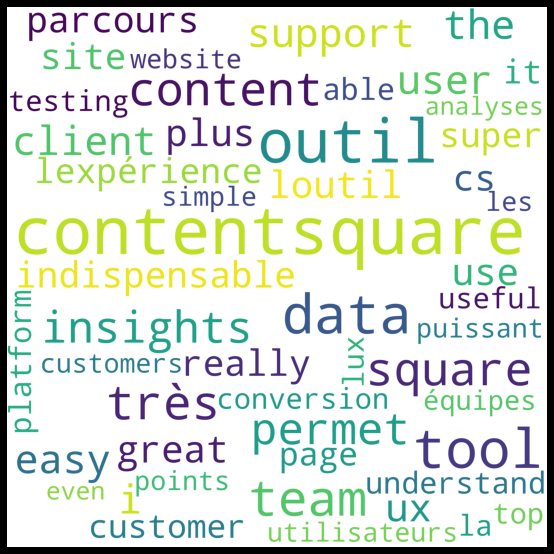

In [84]:
word_freq = dict(zip(new_df.Word, new_df.Frequency))

wc = WordCloud(background_color="white",width=2000,height=2000, max_words=50,relative_scaling=0.5,normalize_plurals=False).generate_from_frequencies(word_freq)

#plt.imshow(wc)

plt.figure( figsize=(15,7.5), facecolor='k')
plt.imshow(wc)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

## Conclusion

The most relevant words that Contentsquare customers use to describe their experience are:

**-outil, tool, data, team, très, content, insights, permet, support, easy, indispensable**

With this analaysis we can confirm that customers are very satisfied and the 4.8 average ranking Contentsquare has in Trustpilot is totally justified.

If we repeat this analysis for only the negative reviews (1,2 and 3 rating) we see that there are no results (0 negative reviews). 

Analyzing this results we can conclude that most costumers do not leave a negative review and Contentsquare does an amazing job to solve customer issues.

## Ideas:

-automatise this analysis and schedule a task to run it and send the results every month with the new customer reviews in order to track
to track the customer satisfaction.

-schedule this task and send a notification everytime we indentify a negative review to contant the customer and help him

-we can use the spreadsheets where we stocked all the data to conduct other analysis if necessary.

Link: https://docs.google.com/spreadsheets/d/1Ju8TeGJtARGHnAL8LizQ31vBirCQKQixgvTvz42eRqg/edit#gid=0